<a href="https://colab.research.google.com/github/afirdousi/pytorch-basics/blob/main/005_pytorch_workflows_5_putting_it_all_together.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using PyTorch version = { torch.__version__ }")
print(f"Using device = { device }")  # We will be doing device agnostic code in this tutorial

Using PyTorch version = 2.0.1+cu118
Using device = cuda


In [45]:
#check which GPU you have (SMI = System Management Interface)
!nvidia-smi

Fri Sep  1 06:30:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    33W /  70W |    821MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [46]:
# Get Data or Create Dummy Data using Linear Regression y = weight * X + bias

weight = 0.5
bias = 0.2

# Build a model to try to estimate the above values of weight and bias

start = 0
end = 1
step = 0.02

# Create X (features) and y (labels)
X = torch.arange( start, end, step ).unsqueeze(dim=1)
#X
y = weight * X + bias

X[:10] , y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.2000],
         [0.2100],
         [0.2200],
         [0.2300],
         [0.2400],
         [0.2500],
         [0.2600],
         [0.2700],
         [0.2800],
         [0.2900]]))

In [47]:
# Split data
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [48]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});


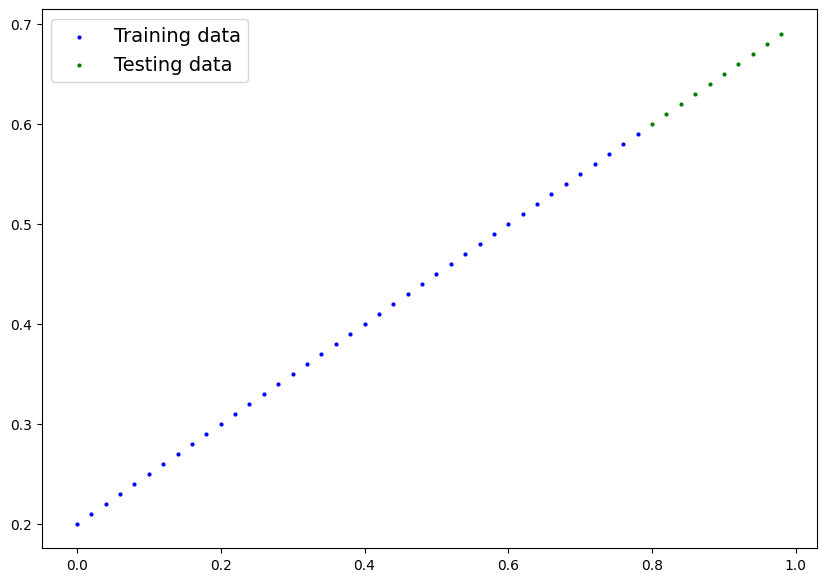

In [37]:
plot_predictions(X_train, y_train, X_test, y_test)

In [38]:
# Build a PyTorch Linear Model

# Create a linear model by subclassing nn.Module

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()

    # Previously we created parameters ourselves using nn.Parameter
    # Now we will use a built in torch linear layer to create those parameters automatically

    # linear models parameters / probing linear / linear transform
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)
    # =1 means one input to this layer and one output to this layer
    # Check https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

In [39]:
torch.manual_seed(42)
model_one = LinearRegressionModel()
model_one, model_one.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [40]:
# Pytorch automatically created the 2 parameters weights and bias parameters for us
# Checkout all the different types of layers available in PyTorch here:
# https://pytorch.org/docs/stable/nn.html


In [41]:
next(model_one.parameters()).device

device(type='cpu')

In [42]:
model_one.to(device)
next(model_one.parameters()).device

device(type='cuda', index=0)

In [43]:
# Training

# For training, we need 4 things:

# Loss function
# Optimizer
# Training Loop
  # - forward loop
  # - calculate loss
  # - call optimizer
  # - backward loop / backpropagation
  # - optimizer step
# Testing Loop

# Setup loss function
loss_func = nn.L1Loss()

# Setup our optimizer
optimizer = torch.optim.SGD( params= model_one.parameters(),
                            lr = 0.01)

In [50]:
# First run the below code without line 10 to 13
# You will get RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)
# Now to write device agnostic code, we will do .to(device) across all


torch.manual_seed(42)
epochs = 200

# Device agnostidc code for data (Put data on target device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_one.train()

  # 1. Forward pass:
  y_predictions = model_one(X_train)

  # 2. Calculate loss
  loss = loss_func(y_predictions, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  # Testing
  model_one.eval()
  with torch.inference_mode():
    test_predictions = model_one(X_test)
    test_loss = loss_func( test_predictions, y_test)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Train Loss: {loss} | Test Loss: {test_loss}")




Epoch: 0 | Train Loss: 0.7216569185256958 | Test Loss: 0.838505208492279
Epoch: 10 | Train Loss: 0.6064471006393433 | Test Loss: 0.7037953734397888
Epoch: 20 | Train Loss: 0.49123722314834595 | Test Loss: 0.5690855979919434
Epoch: 30 | Train Loss: 0.37602734565734863 | Test Loss: 0.4343757629394531
Epoch: 40 | Train Loss: 0.2608174979686737 | Test Loss: 0.2996659278869629
Epoch: 50 | Train Loss: 0.145607590675354 | Test Loss: 0.16495609283447266
Epoch: 60 | Train Loss: 0.030397672206163406 | Test Loss: 0.030246198177337646
Epoch: 70 | Train Loss: 0.0072410800494253635 | Test Loss: 0.001119637512601912
Epoch: 80 | Train Loss: 0.0072410800494253635 | Test Loss: 0.001119637512601912
Epoch: 90 | Train Loss: 0.0072410800494253635 | Test Loss: 0.001119637512601912
Epoch: 100 | Train Loss: 0.0072410800494253635 | Test Loss: 0.001119637512601912
Epoch: 110 | Train Loss: 0.0072410800494253635 | Test Loss: 0.001119637512601912
Epoch: 120 | Train Loss: 0.0072410800494253635 | Test Loss: 0.0011196

In [55]:
# How can we evaluate our model

# original weights and bias
print ( weight, bias )
# One way to check state_dic
model_one.state_dict()

0.5 0.2


OrderedDict([('linear_layer.weight', tensor([[0.5147]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.2015], device='cuda:0'))])

In [56]:
# You can clearly see weights and bias in the model are not almost exactly equivalent to 0.5 and 0.2

In [57]:
# Making and evaluating predictions
model_one.eval()

# Make predictions on test data
with torch.inference_mode():
  y_predictions = model_one(X_test)

y_predictions

tensor([[0.6133],
        [0.6236],
        [0.6339],
        [0.6441],
        [0.6544],
        [0.6647],
        [0.6750],
        [0.6853],
        [0.6956],
        [0.7059]], device='cuda:0')

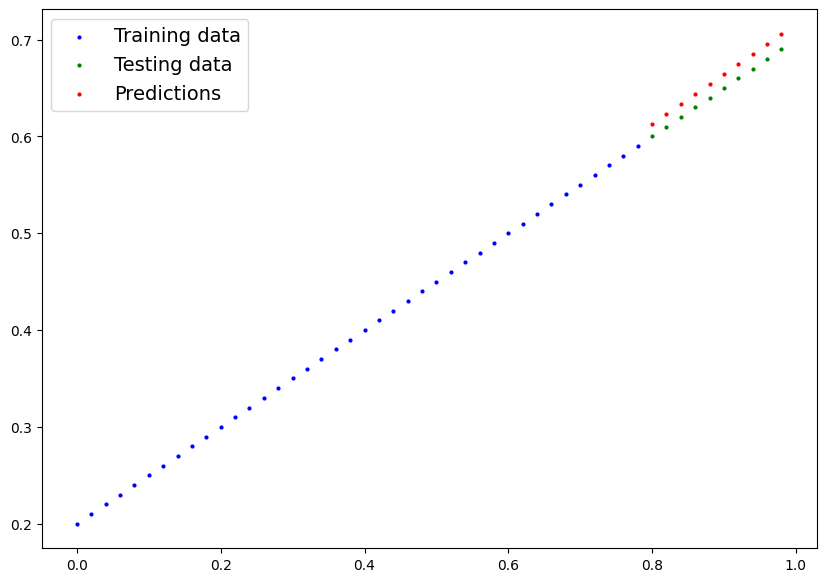

In [59]:
# Check out our model predictions visually

# Run following and you will get TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
# plot_predictions( predictions = y_predictions)
# Because plot_predictions function uses numpy which runs on CPU and our tensors is on GPU

# Fix it by:
plot_predictions( predictions = y_predictions.cpu() )


In [60]:
# Save and load model:

from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "pytorch_test_model_001.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to path = { MODEL_SAVE_PATH }")
torch.save(obj=model_one.state_dict(), # not saving the full, saving dict only
           f=MODEL_SAVE_PATH)

Saving model to path = models/pytorch_test_model_001.pth


In [61]:
# Check if model is saved
!ls -l models

total 4
-rw-r--r-- 1 root root 1251 Sep  1 06:41 pytorch_test_model_001.pth


In [69]:
# 1. Create instance
loaded_model_one = LinearRegressionModel()

# 2. Update instance with saved state_dict
loaded_model_one.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
print(loaded_model_one.state_dict())

# 3. Put the loaded model to device (NEW PART OF THIS LESSON)
loaded_model_one.to(device)

OrderedDict([('linear_layer.weight', tensor([[0.5147]])), ('linear_layer.bias', tensor([0.2015]))])


LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [72]:
# Evaluate loaded model
loaded_model_one.eval()
with torch.inference_mode():
  loaded_model_one_preds = loaded_model_one(X_test)

y_predictions == loaded_model_one_preds # Check to see if the predictions from new loaded model is the same exact same as actual model predictions

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

In [73]:
# Extra exercises:

# Read What is torch.nn, really? Get Deeper understanding read: https://pytorch.org/tutorials/beginner/nn_tutorial.html
# Check PyTorch documentation cheatsheet: https://pytorch.org/tutorials/beginner/ptcheat.html
# Check loading and saving documentation: https://pytorch.org/tutorials/beginner/saving_loading_models.html
# Learn internals of gradient descent and backpropagation
# Wikipedia page for gradient descent
# Gradient Descent Algorithm — a deep dive by Robert Kwiatkowski: https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21
# Videos by 3Blue1Brown on Gradient descent and backpropagation